In [1]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 27.0 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16476 sha256=683486a5fc38d29a639bc7c30fdd1445a31a9c5466baa1bf09d5fb4065939653
  Stored in directory: /home/advaithmalka/.cache/pip/wheels/8b/6f/9b/231a832f811ab6ebb1b32455b177ffc6b8b1cd8de19de70c09
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60993 sha256=b700df5dfc48cd1ecc5b3e89d5fd719c8457150801cd90dbd02642727d14e27b
  Stored in directory: /home/advaithmalka/.cache/pip/wheels/5f/5b/96/fd94bc35962d7c6b699e8814db545155ac91d2b95785e1b035
Successfully built efficientnet-pytorch pretrainedmodels


In [10]:
import segmentation_models_pytorch as smp
import torch

model = smp.Unet(encoder_name="resnet50",  # Change to a different backbone if needed
                 encoder_weights="imagenet",  # Use pretrained weights
                 in_channels=1,  # Change to 3 if RGB images
                 classes=1,
                decoder_dropout=0.3,
                decoder_channels=(512, 256, 128, 64, 32)) # increase decoder

In [ ]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import os
from glob import glob
from sklearn.model_selection import train_test_split


ucph_images = sorted(glob(os.path.join("dataset/UCPH_IMAGE_cristae_dataset/images/", "*.png")))
ucph_masks = sorted(glob(os.path.join("dataset/UCPH_IMAGE_cristae_dataset/filled_binary_masks/", "*.png")))

# Combine files
image_files = ucph_images
mask_files = ucph_masks

# Split the data into 80% train and 20% test

train_img_files, test_img_files, train_mask_files, test_mask_files = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

len(train_img_files),len(test_img_files), len(train_mask_files), len(test_mask_files)

(119, 30, 119, 30)

In [3]:
test_img_files

['dataset/UCPH_IMAGE_cristae_dataset/images/00074.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00018.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00118.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00079.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00077.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00031.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00065.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00141.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00069.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00083.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00110.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00012.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00036.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00009.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00019.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00057.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/00137.png',
 'dataset/UCPH_IMAGE_cristae_dataset/images/0007

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
from PIL import Image

class CristaeDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.mask_transform = mask_transform  # Separate transform for masks

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)  # Load mask
        
        img = img / 255.0  # Normalize to [0, 1]
        mask = (mask > 0).astype(np.float32)  # Convert mask to binary
        
        img = Image.fromarray((img * 255).astype(np.uint8))
        mask = Image.fromarray((mask * 255).astype(np.uint8))  # Keep as uint8 for transforms
        
        if self.transform:
            img = self.transform(img)  # Apply image transforms
        
        if self.mask_transform:
            mask = self.mask_transform(mask)  # Apply mask-specific transforms

        return img, mask


image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3,3), sigma=(0.1, 2.0)),
    transforms.ToTensor(),  # Convert to tensor
])


mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),  
    transforms.ToTensor(),
])

# Test transforms (only resizing, no augmentation)
test_image_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

test_mask_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor(),
])

# Datasets
train_dataset = CristaeDataset(train_img_files, train_mask_files, transform=image_transform, mask_transform=mask_transform)
test_dataset = CristaeDataset(test_img_files, test_mask_files, transform=test_image_transform, mask_transform=test_mask_transform)

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import numpy as np

class EarlyStopping:

    def __init__(self, patience=5, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): how long to wait after last time validation loss improved.
            verbose (bool): if True, prints a message for each validation loss improvement. 
            delta (float): minimum change in the monitored quantity to qualify as an improvement.
            path (str): path for the checkpoint to be saved to.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
        elif val_loss > self.best_score - self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

def train_model(model, train_loader, test_loader, num_epochs=30, patience=5):
    # Device configuration
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Optimizer with adaptive learning rate
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.5,  # Reduce LR by half
        patience=3,  # Wait 3 epochs before reducing LR
        min_lr=1e-5  # Minimum learning rate
    )
    
    loss_fn = smp.losses.DiceLoss(mode='binary')

   
    early_stopping = EarlyStopping(
        patience=patience, 
        verbose=True, 
        path="models/best_model_checkpoint_cristae.pt"
    )
    
    # Training loop
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            imgs, masks = imgs.to(device), masks.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = loss_fn(outputs, masks)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
       
        train_loss = epoch_loss / len(train_loader)
        print(f"Train Loss after Epoch {epoch+1}: {train_loss:.4f}")
        
        # testing phase
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for imgs, masks in test_loader:
                imgs, masks = imgs.to(device), masks.to(device)
                outputs = model(imgs)
                loss = loss_fn(outputs, masks)
                test_loss += loss.item()
        
       
        test_loss = test_loss / len(test_loader)
        print(f"Test Loss after Epoch {epoch+1}: {test_loss:.4f}")
        
       
        scheduler.step(test_loss)
        
      
        early_stopping(test_loss, model)
 
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    # Load the best model
    model.load_state_dict(torch.load("models/best_model_checkpoint_cristae.pt"))
    
    return model

model = train_model(model, train_loader, test_loader)

Epoch 1/30: 100%|██████████| 30/30 [00:01<00:00, 17.71it/s]


Train Loss after Epoch 1: 0.9211
Test Loss after Epoch 1: 0.8972
Validation loss decreased (inf --> 0.897156).  Saving model ...


Epoch 2/30: 100%|██████████| 30/30 [00:01<00:00, 18.30it/s]


Train Loss after Epoch 2: 0.8665
Test Loss after Epoch 2: 0.8377
Validation loss decreased (0.897156 --> 0.837685).  Saving model ...


Epoch 3/30: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s]


Train Loss after Epoch 3: 0.7958
Test Loss after Epoch 3: 0.7261
Validation loss decreased (0.837685 --> 0.726135).  Saving model ...


Epoch 4/30: 100%|██████████| 30/30 [00:01<00:00, 18.32it/s]


Train Loss after Epoch 4: 0.7155
Test Loss after Epoch 4: 0.6639
Validation loss decreased (0.726135 --> 0.663853).  Saving model ...


Epoch 5/30: 100%|██████████| 30/30 [00:01<00:00, 18.16it/s]


Train Loss after Epoch 5: 0.6613
Test Loss after Epoch 5: 0.6059
Validation loss decreased (0.663853 --> 0.605877).  Saving model ...


Epoch 6/30: 100%|██████████| 30/30 [00:01<00:00, 18.36it/s]


Train Loss after Epoch 6: 0.5903
Test Loss after Epoch 6: 0.5820
Validation loss decreased (0.605877 --> 0.582036).  Saving model ...


Epoch 7/30: 100%|██████████| 30/30 [00:01<00:00, 17.72it/s]


Train Loss after Epoch 7: 0.5257
Test Loss after Epoch 7: 0.5092
Validation loss decreased (0.582036 --> 0.509185).  Saving model ...


Epoch 8/30: 100%|██████████| 30/30 [00:01<00:00, 18.10it/s]


Train Loss after Epoch 8: 0.4732
Test Loss after Epoch 8: 0.5134
EarlyStopping counter: 1 out of 5


Epoch 9/30: 100%|██████████| 30/30 [00:01<00:00, 18.34it/s]


Train Loss after Epoch 9: 0.4213
Test Loss after Epoch 9: 0.4950
Validation loss decreased (0.509185 --> 0.494962).  Saving model ...


Epoch 10/30: 100%|██████████| 30/30 [00:01<00:00, 18.36it/s]


Train Loss after Epoch 10: 0.3964
Test Loss after Epoch 10: 0.4372
Validation loss decreased (0.494962 --> 0.437162).  Saving model ...


Epoch 11/30: 100%|██████████| 30/30 [00:01<00:00, 18.38it/s]


Train Loss after Epoch 11: 0.3595
Test Loss after Epoch 11: 0.4563
EarlyStopping counter: 1 out of 5


Epoch 12/30: 100%|██████████| 30/30 [00:01<00:00, 18.42it/s]


Train Loss after Epoch 12: 0.3260
Test Loss after Epoch 12: 0.4125
Validation loss decreased (0.437162 --> 0.412454).  Saving model ...


Epoch 13/30: 100%|██████████| 30/30 [00:01<00:00, 18.35it/s]


Train Loss after Epoch 13: 0.3037
Test Loss after Epoch 13: 0.4085
Validation loss decreased (0.412454 --> 0.408468).  Saving model ...


Epoch 14/30: 100%|██████████| 30/30 [00:01<00:00, 18.34it/s]


Train Loss after Epoch 14: 0.2763
Test Loss after Epoch 14: 0.4019
Validation loss decreased (0.408468 --> 0.401950).  Saving model ...


Epoch 15/30: 100%|██████████| 30/30 [00:01<00:00, 18.37it/s]


Train Loss after Epoch 15: 0.2546
Test Loss after Epoch 15: 0.3826
Validation loss decreased (0.401950 --> 0.382580).  Saving model ...


Epoch 16/30: 100%|██████████| 30/30 [00:01<00:00, 18.36it/s]


Train Loss after Epoch 16: 0.2396
Test Loss after Epoch 16: 0.3803
Validation loss decreased (0.382580 --> 0.380269).  Saving model ...


Epoch 17/30: 100%|██████████| 30/30 [00:01<00:00, 18.33it/s]


Train Loss after Epoch 17: 0.2288
Test Loss after Epoch 17: 0.3782
Validation loss decreased (0.380269 --> 0.378152).  Saving model ...


Epoch 18/30: 100%|██████████| 30/30 [00:01<00:00, 18.35it/s]


Train Loss after Epoch 18: 0.2045
Test Loss after Epoch 18: 0.3957
EarlyStopping counter: 1 out of 5


Epoch 19/30: 100%|██████████| 30/30 [00:01<00:00, 17.48it/s]


Train Loss after Epoch 19: 0.1925
Test Loss after Epoch 19: 0.3865
EarlyStopping counter: 2 out of 5


Epoch 20/30: 100%|██████████| 30/30 [00:01<00:00, 17.60it/s]


Train Loss after Epoch 20: 0.1781
Test Loss after Epoch 20: 0.4062
EarlyStopping counter: 3 out of 5


Epoch 21/30: 100%|██████████| 30/30 [00:01<00:00, 17.28it/s]


Train Loss after Epoch 21: 0.1772
Test Loss after Epoch 21: 0.3944
EarlyStopping counter: 4 out of 5


Epoch 22/30: 100%|██████████| 30/30 [00:01<00:00, 18.27it/s]


Train Loss after Epoch 22: 0.1617
Test Loss after Epoch 22: 0.3824
EarlyStopping counter: 5 out of 5
Early stopping triggered


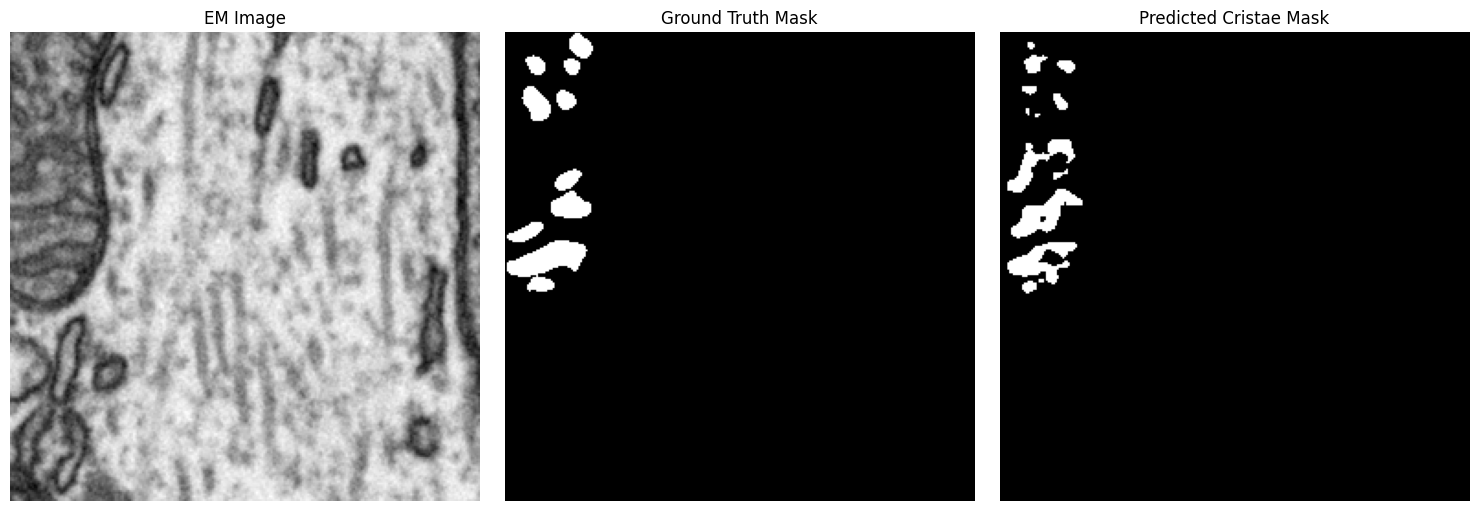

In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
import numpy as np
import segmentation_models_pytorch as smp


# model.load_state_dict(torch.load("models/cristae_unet.pt", map_location=torch.device('cuda'))) 

TEST_IMG_NUMBER = "00128" # 30, 102, 46, 128, 129

# Load the test image and the corresponding ground truth mask
test_img = cv2.imread(f"dataset/UCPH_IMAGE_cristae_dataset/images/{TEST_IMG_NUMBER}.png", cv2.IMREAD_GRAYSCALE) / 255.0

# test_img = cv2.imread(f"dataset/AV-39/raw/Image5.tif", cv2.IMREAD_GRAYSCALE) / 255.0 #23, 18,5


eval_transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL image
    transforms.Resize((256, 256)),       # Resize to 256x256 or your desired size
    transforms.ToTensor(),               # Convert to tensor
])



# Apply transformations
test_img = eval_transform(test_img)

# Add a batch dimension and send to device (cuda or cpu)
test_img = test_img.unsqueeze(0).to(torch.device('cuda'))  # Add 

# Load the ground truth mask 
ground_truth_mask = cv2.imread(f"dataset/UCPH_IMAGE_cristae_dataset/filled_binary_masks/{TEST_IMG_NUMBER}.png", cv2.IMREAD_GRAYSCALE)
# ground_truth_mask = cv2.imread(f"dataset/AV-39/masks/Mask5.tif", cv2.IMREAD_GRAYSCALE)
ground_truth_mask = (ground_truth_mask > 0.5).astype(np.uint8)  # Apply threshold if necessary

# Get the model's prediction
model.eval()
with torch.inference_mode():
    pred_mask = model(test_img).squeeze().cpu().numpy()
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # Apply threshold

# Plot the real image, predicted mask, and ground truth mask
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Display the real image
real_img = test_img.squeeze().cpu() * 225.0
axes[0].imshow(real_img, cmap='gray')
axes[0].set_title("EM Image")
axes[0].axis('off')



# Display the ground truth mask
axes[1].imshow(ground_truth_mask, cmap='gray')
axes[1].set_title("Ground Truth Mask")
axes[1].axis('off')

# Display the predicted mask
axes[2].imshow(pred_mask, cmap='gray')
axes[2].set_title("Predicted Cristae Mask")
axes[2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:

eval_transform = transforms.Compose([
    transforms.ToPILImage(),             # Convert numpy array to PIL image
    transforms.Resize((256, 256)),       # Resize to 256x256 or your desired size
    transforms.ToTensor(),               # Convert to tensor
])
# Apply transformations
other_img = eval_transform(test_img)

# Add a batch dimension (if necessary) and send to the device
other_img = test_img.unsqueeze(0).to("cuda")  # Add batch dimension and send to device


In [ ]:
import cv2
import numpy as np

def get_mask_properties(mask):

    mask = (mask * 255).astype(np.uint8)  # Convert to uint8 for OpenCV
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    area = sum(cv2.contourArea(cnt) for cnt in contours)  # Compute total area
    perimeter = sum(cv2.arcLength(cnt, True) for cnt in contours)  # Compute total perimeter

    return area, perimeter


area, perimeter = get_mask_properties(pred_mask)
area_real, perimeter_real = get_mask_properties(ground_truth_mask)

print(f"Predicted Mask Area: {area:.2f} pixels²")
print(f"Predicted Mask Perimeter: {perimeter:.2f} pixels")

print(f"Predicted Mask Area: {area_real:.2f} pixels²")
print(f"Predicted Mask Perimeter: {perimeter_real:.2f} pixels")

Predicted Mask Area: 1392.50 pixels²
Predicted Mask Perimeter: 477.14 pixels
Predicted Mask Area: 1384.00 pixels²
Predicted Mask Perimeter: 485.73 pixels


Processing first 5 images...


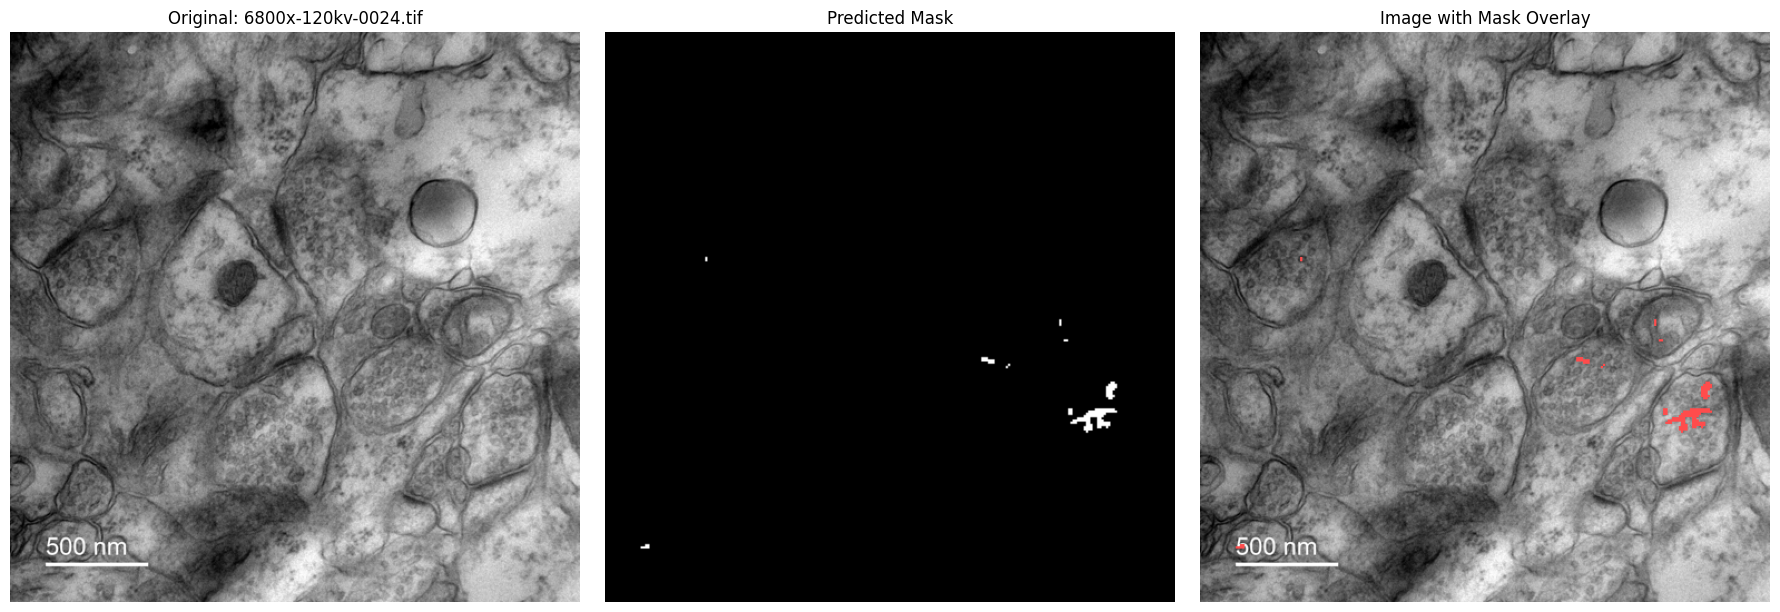

Press Enter to continue to next image... 


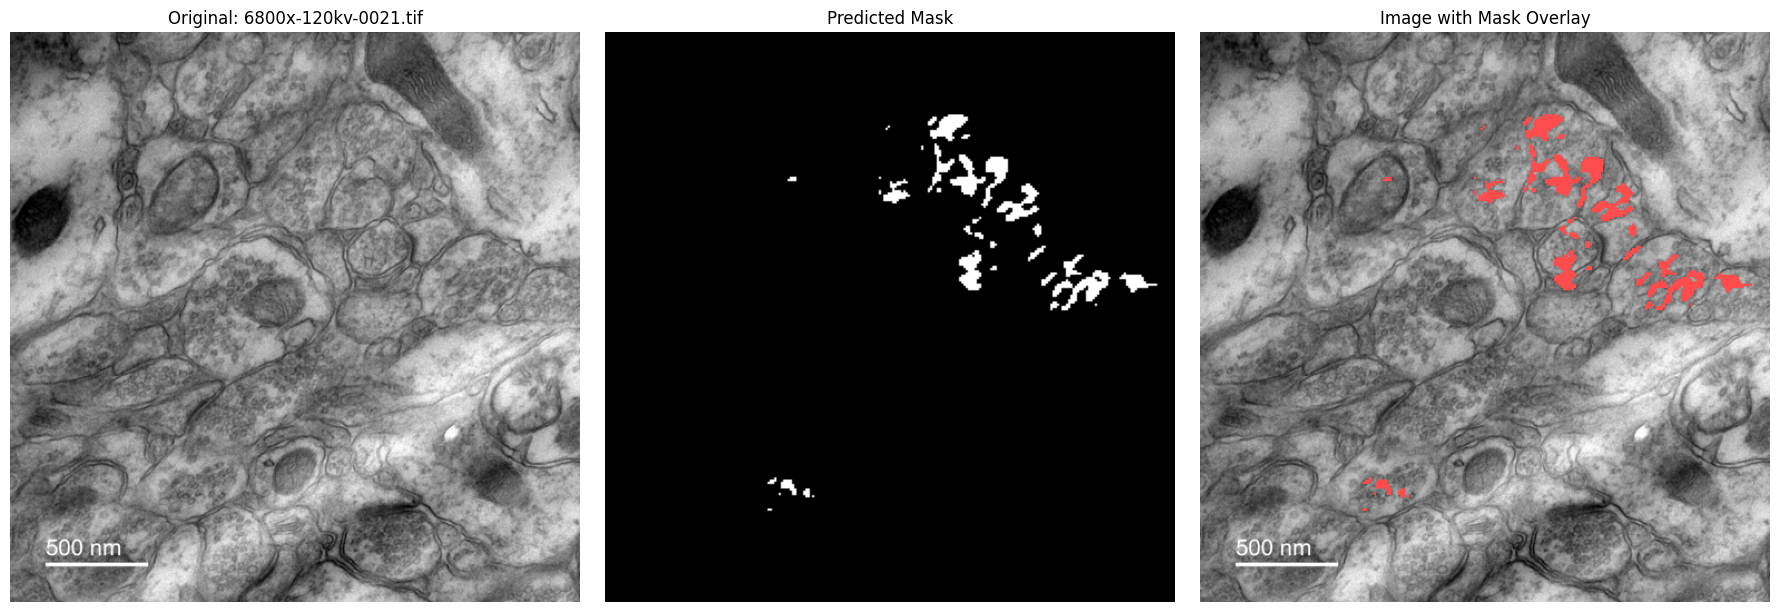

Press Enter to continue to next image... 


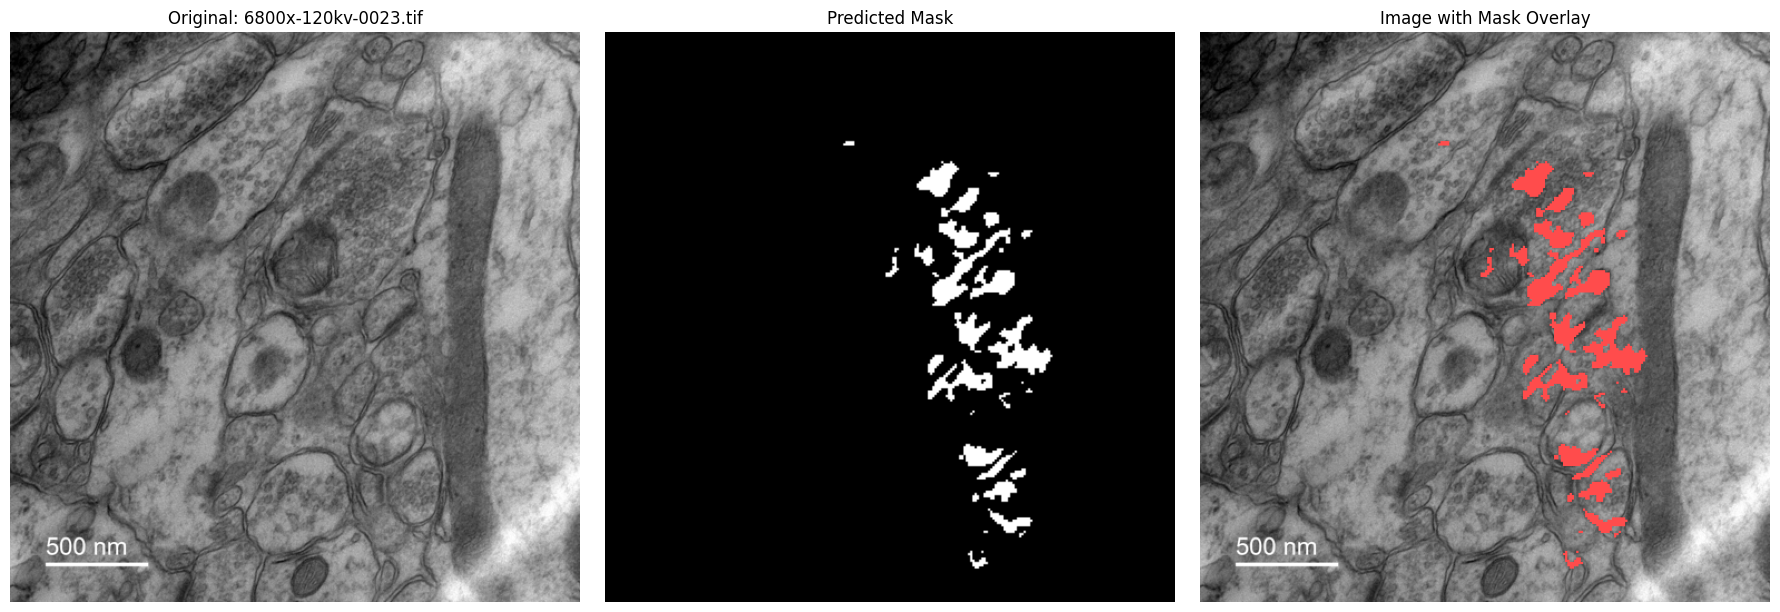

Press Enter to continue to next image... 


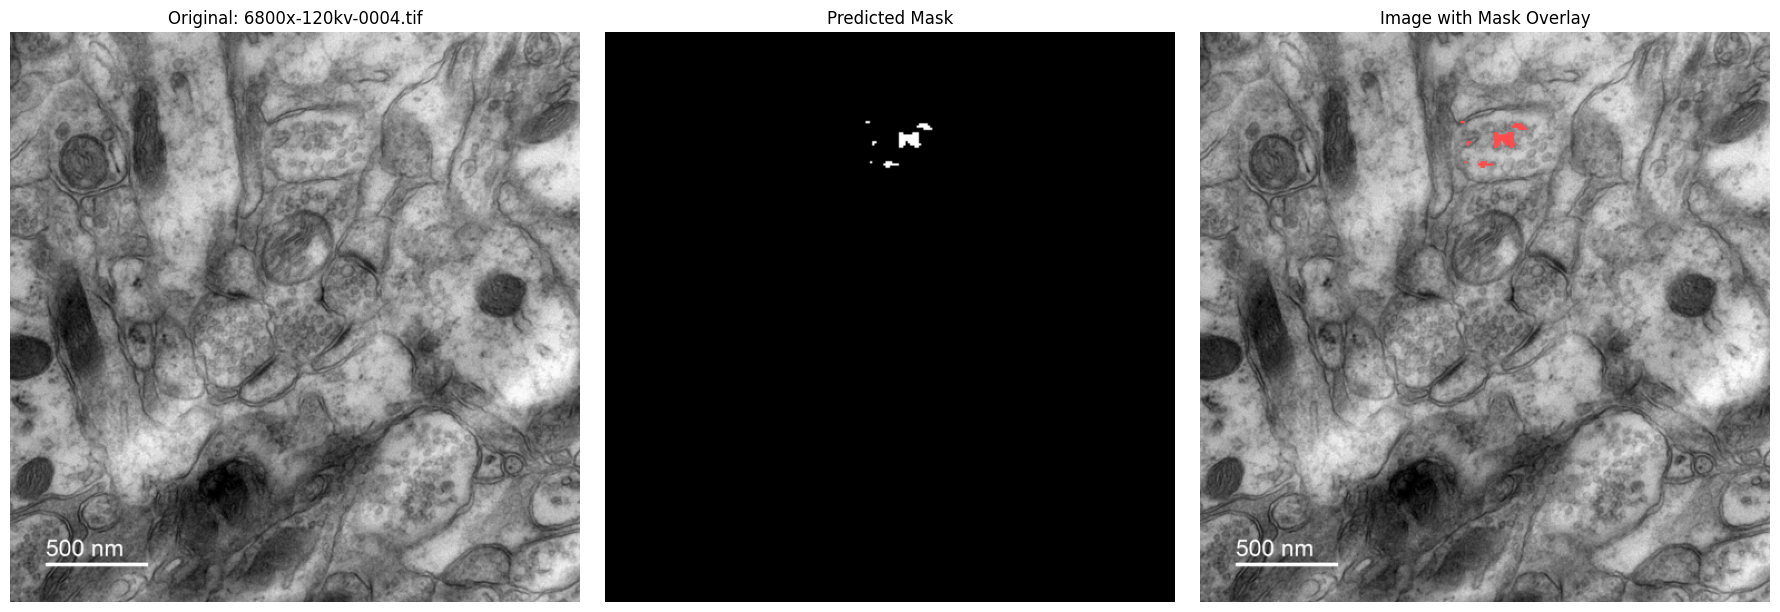

Press Enter to continue to next image... 


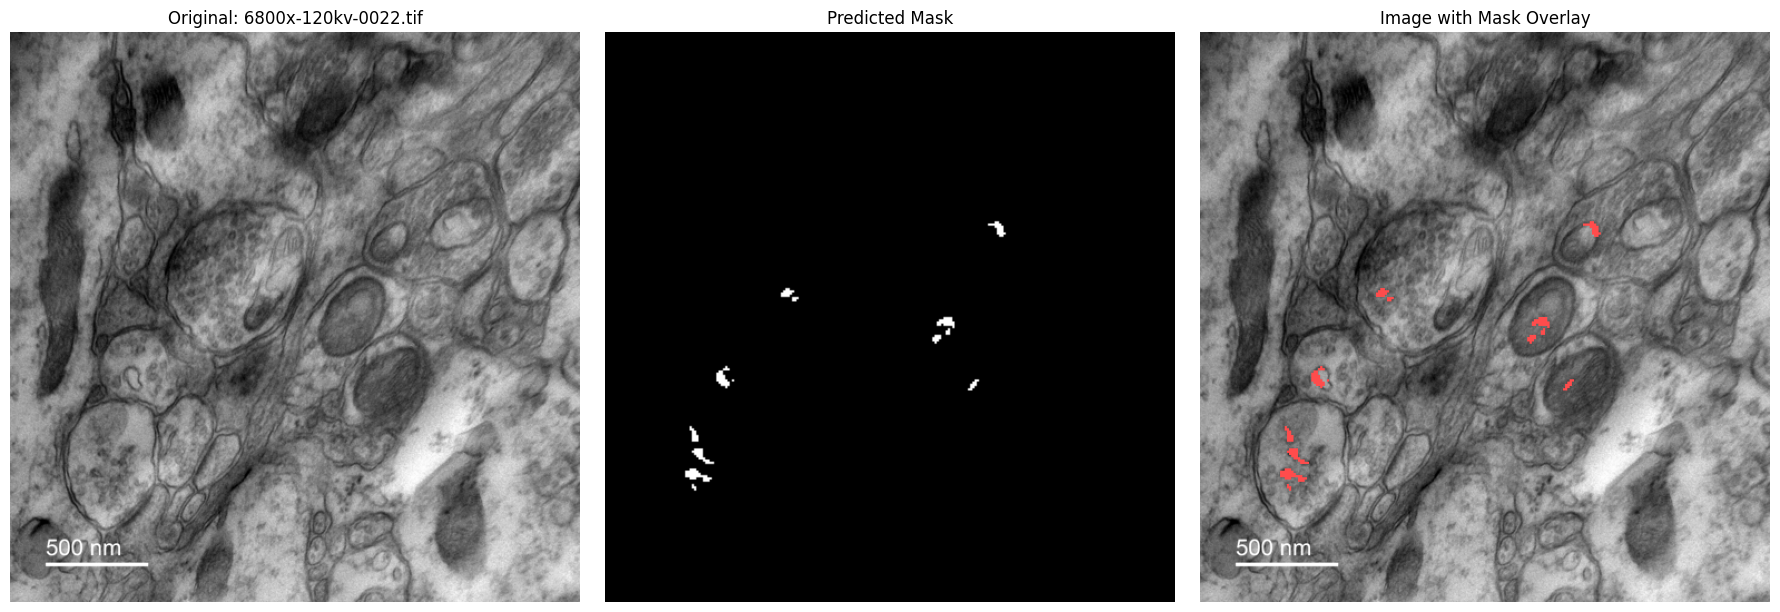

Press Enter to continue to next image... 


In [ ]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from matplotlib.colors import ListedColormap

def batch_evaluate_model(model, image_folder, max_images=None, output_folder=None, device="cuda"):

    # Create output folder if specified and doesn't exist
    if output_folder and not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Define image transformation
    eval_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    
    # Get all image files in the folder
    image_files = [f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg', '.tif'))]
    
    # Limit the number of images if specified
    if max_images is not None:
        image_files = image_files[:max_images]
        print(f"Processing first {len(image_files)} images...")
    
    # Process each image
    model.eval()
    for img_file in image_files:
        # Load image
        img_path = os.path.join(image_folder, img_file)
        raw_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) / 255.0
        
        # Prepare image for model
        processed_img = eval_transform(raw_img)
        input_tensor = processed_img.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.inference_mode():
            pred_mask = model(input_tensor)
            pred_mask = pred_mask.squeeze().cpu().numpy()
            pred_mask_binary = (pred_mask > 0.5).astype(np.uint8)
            
        original_h, original_w = raw_img.shape
        pred_mask_resized = cv2.resize(pred_mask_binary, (original_w, original_h), 
                               interpolation=cv2.INTER_NEAREST)
                               
        # Create visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Original image
        axes[0].imshow(raw_img, cmap='gray')
        axes[0].set_title(f"Original: {img_file}")
        axes[0].axis('off')
        
        # Predicted mask
        axes[1].imshow(pred_mask_binary, cmap='gray')
        axes[1].set_title("Predicted Mask")
        axes[1].axis('off')
        
        # Overlay mask on original
        # Create a transparent overlay where mask is applied
        overlay = np.zeros((*raw_img.shape, 3))
        overlay[..., 0] = raw_img  # Red channel gets original image
        overlay[..., 1] = raw_img  # Green channel gets original image
        overlay[..., 2] = raw_img  # Blue channel gets original image
        
        # Apply red overlay where mask is present
        overlay[pred_mask_resized == 1, 0] = 1.0  # Red channel set to max
        overlay[pred_mask_resized == 1, 1] = 0.3  # Reduce green to create reddish tint
        overlay[pred_mask_resized == 1, 2] = 0.3  # Reduce blue to create reddish tint
        
        axes[2].imshow(overlay)
        axes[2].set_title("Image with Mask Overlay")
        axes[2].axis('off')
        
        plt.tight_layout()
        
        # Save or display
        if output_folder:
            output_path = os.path.join(output_folder, f"result_{os.path.splitext(img_file)[0]}.png")
            plt.savefig(output_path, dpi=150, bbox_inches='tight')
            plt.close()
            print(f"Saved result for {img_file}")
        else:
            plt.show()
            input("Press Enter to continue to next image...")
            plt.close()

# Define paths
image_folder = "dataset/AV-39/"
output_folder = "evaluation_results"

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming model is already loaded
# model = YourModel().to(device)
# model.load_state_dict(torch.load("your_model_weights.pth"))

# Run batch evaluation - process only the first 5 images
batch_evaluate_model(model, image_folder, max_images=5, output_folder=None, device=device)